# Runtime Set-Up



Mount Google drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Change directory to project folder:

In [2]:
cd '/content/drive/MyDrive/'

/content/drive/MyDrive


Git commands:

In [ ]:
#!git branch 'model-training'
!git checkout 'model-training'

fatal: not a git repository (or any parent up to mount point /content)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


See specs of GPU we've been allocated in Google Colab:

In [ ]:
!nvidia-smi

Mon Aug 30 21:32:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Package Set-Up

Install required packages onto Google Colab instance:

In [3]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 5.0 MB/s 
     |████████████████████████████████| 3.3 MB 57.2 MB/s 
     |████████████████████████████████| 636 kB 51.8 MB/s 
     |████████████████████████████████| 895 kB 51.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Perform required imports:

In [5]:
# PyTorch imports:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils import data 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset

# HuggingFace imports:
import transformers
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW

# Data manipulation imports:
import pandas as pd
from sklearn.model_selection import train_test_split

# Plotting imports:
import seaborn as sns
import matplotlib.pyplot as plt

# Misc imports:
import itertools
import random
import time
import shutil
from math import inf

Set verbosity of HuggingFace library so that it only prints 'Critical' messages:

In [ ]:
transformers.logging.set_verbosity(transformers.logging.CRITICAL)

See if GPU is available:

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Define global variables:

In [7]:
RANDOM_SEED = 42
MODEL_NAME = "distilbert-base-uncased"

For reproducibility, set random seed:

In [ ]:
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Load and Inspect Data

Load data from CSV then split into features and labels:

In [ ]:
# Load data:
text_dir = "./train.csv"
text_df = pd.read_csv(text_dir)
text_df = text_df.loc[:,"excerpt":"standard_error"]
# Split loaded data into features X and labels y:
features, labels = text_df.loc[:,"excerpt"].to_frame(), text_df.loc[:,"target"].to_frame()

Create Tokenizer (will be treated as a global variable):

In [8]:
TOKENIZER = DistilBertTokenizer.from_pretrained(MODEL_NAME, use_fast=True, do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
TOKENIZER.save_pretrained('tokenizer')

Workout maximum size of input strings for BERT tokenizer:

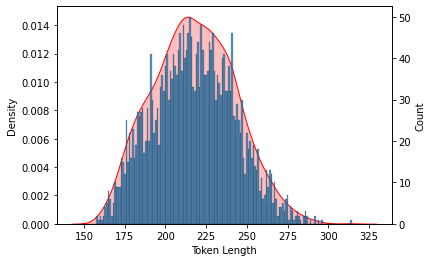

In [ ]:
token_len = []
for text in features["excerpt"]:
  tokens = TOKENIZER.encode(text, truncation=False)
  token_len.append(len(tokens))
fig, ax1 = plt.subplots()
plt.xlabel('Token Length')
sns.kdeplot(data=token_len, ax=ax1, color='r', fill=True)
ax2 = ax1.twinx()
sns.histplot(data=token_len, discrete=True, ax=ax2)
sns.set_style("darkgrid")

# Pre-Process Data

Split data into training and test sets (both are treated as global variables):

In [ ]:
# Perform test-train split: 
test_frac = 0.1
train_features, test_features, train_labels, test_labels \
  = train_test_split(features, labels, test_size=test_frac, random_state=RANDOM_SEED)
TRAIN_DATA = {"features": train_features, "labels": train_labels}
TEST_DATA = {"features": test_features, "labels": test_labels}

Functions to split sentences into chunks and then tokenise those chunks:

In [ ]:
# Processes each chunk of tokenized text so it can be 'understood' by BERT:
def process_chunks(id_chunk, mask_chunk, max_len, start_id=101, end_id=102):
  # Add start and stop IDs:
  id_chunk = torch.cat([torch.tensor([start_id]), id_chunk, torch.tensor([end_id])])
  mask_chunk = torch.cat([torch.ones(1), mask_chunk, torch.ones(1)])
  # Pad chunks if required:
  if len(id_chunk) < max_len:
    pad_len = max_len - len(id_chunk)
    id_chunk = torch.cat([id_chunk, torch.zeros(pad_len)])
    mask_chunk = torch.cat([mask_chunk, torch.zeros(pad_len)])
  return (id_chunk, mask_chunk)

def tokenise_chunks(features, tokenizer, max_len, cutoff):
  X_id, X_mask = [], []
  for text in features["excerpt"]:
    id_list, mask_list = [], []
    tokens = tokenizer.encode_plus(text, add_special_tokens=False, return_tensors='pt')
    ids = tokens["input_ids"][0].split(max_len-2)
    masks = tokens["attention_mask"][0].split(max_len-2)
    for id_chunk, mask_chunk in zip(ids, masks):
      id_chunk, mask_chunk = process_chunks(id_chunk, mask_chunk, max_len)
      id_list.append(id_chunk), mask_list.append(mask_chunk)
    X_id.append(torch.stack(id_list, dim=0))
    X_mask.append(torch.stack(mask_list, dim=0))
  # Pad list of IDs and Masks so that they're now both stored in a single tensor
  # of dimensions (batch size × num of chunks × num of mask/id values):
  X_id = pad_sequence(X_id, batch_first=True, padding_value=0)
  X_mask = pad_sequence(X_mask, batch_first=True, padding_value=0)
  X_id, X_mask = torch.as_tensor(X_id, dtype=torch.int64), torch.as_tensor(X_mask, dtype=torch.int64)
  return (X_id, X_mask)

Function to create training dataset:

In [ ]:
# For creating the training dataset:
#    - dataset output includes X_id, X_mask, X_wt, and y
#    - X_id and X_mask are (batch size × num of chunks × num of mask/id values)
#    - X_wt is (batch size × num of chunks)
#    - y is (batch size × num of outputs)
def create_train_dataset(train_data, tokenizer, max_len, cutoff=30, print_flag=False):
  train_features, train_labels = train_data["features"], train_data["labels"]
  # Convert labels to PyTorch tensors:
  y = torch.tensor(train_labels["target"].values, dtype=torch.float32)
  y = y.reshape((len(y), 1)) 
  # Split text into chunks and tokenise those chunks:
  X_id, X_mask = tokenise_chunks(train_features, tokenizer, max_len, cutoff)
  # Repeat labels for every chunk:
  num_chunks_per_ex = X_id.shape[1]
  y = y.repeat_interleave(num_chunks_per_ex, 0)
  # Reshape X_id and X_mask to ([batch size*num of chunks] × num of mask/id values):
  new_shape = (X_id.shape[0]*X_id.shape[1], X_id.shape[2])
  X_id, X_mask = X_id.reshape(new_shape), X_mask.reshape(new_shape)
  # Create mask to throw away sentence chunks below cutoff length:
  chunk_mask = torch.sum(X_mask, axis=1) >= cutoff
  if print_flag:
    # Compute number of (non-empty) sentence chunks and tokens to throw away:
    thrown_chunks = (torch.logical_and(torch.logical_not(chunk_mask), torch.sum(X_mask, axis=1)>0)).sum()
    total_chunks = (torch.sum(X_mask, axis=1) > 0).sum()
    thrown_tokens = X_mask[torch.logical_not(chunk_mask),:].sum()
    total_tokens = X_mask.sum()
    print("Training Data Processing Summary:")
    print(f"Number of sentence chunks discarded = {torch.sum(thrown_chunks)}/{torch.sum(total_chunks)}")
    print(f"Number of tokens discarded = {thrown_tokens}/{total_tokens}")
  # Throw away sentence chunks which contain fewer than cutoff ids:
  X_id, X_mask, y = X_id[chunk_mask,:], X_mask[chunk_mask,:], y[chunk_mask,:]
  # Place in dataset:
  train_dataset = TensorDataset(X_id, X_mask, y)
  return train_dataset

Function to create test dataset:

In [ ]:
# For creating the test dataset:
#    - dataset output includes X_id, X_mask, and y
#    - X_id and X_mask are ([batch size*num of chunks] × num of mask/id values)
#    - y is ([batch size*num of chunks] × num of outputs)
def create_test_dataset(test_data, tokenizer, max_len, cutoff=30):
  test_features, test_labels = test_data["features"], test_data["labels"]
  # Convert labels to PyTorch tensors:
  y = torch.tensor(test_labels["target"].values, dtype=torch.float32)
  y = y.reshape((len(y), 1)) 
  # Split text into chunks and tokenise those chunks:
  X_id, X_mask = tokenise_chunks(test_features, tokenizer, max_len, cutoff)
  # Compute weightings for the sentence chunks:
  X_wts = torch.sum(X_mask, axis=2, keepdim=True)/torch.sum(X_mask, axis=(1,2), keepdim=True)
  X_wts = X_wts.reshape(X_mask.shape[0:-1])
  X_wts = torch.as_tensor(X_wts, dtype=torch.float32)
  # Place tensors into dataset:
  test_dataset = TensorDataset(X_id, X_mask, X_wts, y)
  return test_dataset

# Create Dataset and DataLoader Objects

Define custom Dataset class:

In [ ]:
class ReadingDifficultyDataset(data.Dataset):
  def __init__(self, dataset, mode):
    self.dataset = dataset
    self.mode=mode

  def __len__(self):
    return len(self.dataset)
    
  def __getitem__(self, idx):
    item_i = self.dataset[idx]
    if self.mode=="train":
      item_i = {"id": item_i[0],
                "mask": item_i[1],
                "y": item_i[2]}
    elif self.mode=="test":
      item_i = {"id": item_i[0],
                "mask": item_i[1],
                "wt": item_i[2],
                "y": item_i[3]}
    return item_i

Define function to create DataLoaders:

In [ ]:
BATCH_SIZE = 32

def create_train_dataloader(train_data, max_len, tokenizer, batch_size=BATCH_SIZE):
  train_dataset = create_train_dataset(train_data, tokenizer, max_len)
  train_dataset = ReadingDifficultyDataset(train_dataset, "train")
  train_dl = data.DataLoader(train_dataset,
                             batch_size=batch_size,
                             shuffle=True)
  return train_dl

def create_test_dataloader(test_data, max_len, tokenizer, batch_size=BATCH_SIZE):
  test_dataset = create_test_dataset(test_data, tokenizer, max_len)
  test_dataset = ReadingDifficultyDataset(test_dataset, "test")
  test_dl = data.DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)
  return test_dl

# Create BERT Model

Define BERT model regression class - note that : the actual targt value and the standard deviation of that target value. Since standard deviations must be positive, the output of the regressor must be passed through an `exp` before being outputted, thereby ensuring that output is positive:

In [ ]:
class BertRegression():
  def __init__(self, num_pred, drop_prob):
    self.num_pred = num_pred
    # Instantiate pre-trained BERT encoder:
    self.model = \
     DistilBertForSequenceClassification.from_pretrained(MODEL_NAME,
                                                         problem_type="regression",
                                                         num_labels=num_pred,
                                                         seq_classif_dropout=drop_prob,
                                                         output_attentions=False,
                                                         output_hidden_states=False)

  def predict(self, id, att_mask, wt):
    if self.model.training:
      self.model.eval()
    in_shape = (id.shape[0]*id.shape[1], id.shape[2])
    out_shape = id.shape[0:-1] + (self.num_pred,)
    id, att_mask = id.reshape(in_shape), att_mask.reshape(in_shape)
    # Get pooled [CLS] token value from BERT output:
    logits = self.model(input_ids=id, attention_mask=att_mask)["logits"]
    logits = logits.reshape(out_shape)
    pred = torch.einsum("ij,ijk->ik", wt, torch.nan_to_num(logits))
    return pred

# Train and Evaluation Loops

Define training loop:

In [ ]:
def train_epoch(model_obj, data_loader, optimiser, device):
  model_obj.model.train()
  total_loss = 0
  for d in data_loader:
    # Unpack training data:
    id = d["id"].to(device)
    mask = d["mask"].to(device)
    y = d["y"].to(device)
    # Produce predictions:
    model_obj.model.zero_grad()
    output = model_obj.model(input_ids=id, 
                             attention_mask=mask, 
                             labels=y)
    total_loss += output.loss.item()
    output.loss.backward()
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimiser.step()
  return total_loss/len(data_loader)

Define evaluation loop:

In [ ]:
def test_epoch(model_obj, data_loader, test_loss_fun, device):
  model_obj.model.eval()
  total_loss = 0
  with torch.no_grad():
    for d in data_loader:
      # Unpack training data:
      id = d["id"].to(device)
      mask = d["mask"].to(device)
      wt = d["wt"].to(device)
      y = d["y"].to(device)
      # Produce predictions:
      pred = model_obj.predict(id, mask, wt)
      loss = test_loss_fun(pred.squeeze(), y.squeeze())
      total_loss += loss
  return total_loss/len(data_loader)

Function which trains model for a give set of hyperparameters:

In [ ]:
def train_model(model_obj, optimiser, train_dl, test_dl, num_epoch, device, 
               print_msg=False, delete_model=True):

  # Define print function to use depending on if user wants printed outputs:
  my_print = print if print_msg else lambda my_str: None

  # Move test loss and model to GPU:
  test_loss_fun = nn.MSELoss().to(device)
  model_obj.model.to(device)

  # Train network:
  hist = {"train": [], "test": []}
  best_loss = inf
  for i in range(num_epoch):
    my_print(f'Epoch {i+1}/{num_epoch}')
    my_print(10*'-')
    # Compute training loss:
    time_0 = time.time()
    train_loss = train_epoch(model_obj, train_dl, optimiser, device)
    time_1 = time.time()
    my_print(f"Train loss = {train_loss:.6f}")
    my_print(f"Training time = {time_1-time_0:.2f} seconds")
    # Compute test loss:
    time_0 = time.time()
    test_loss = test_epoch(model_obj, test_dl, test_loss_fun, device)
    time_1 = time.time()
    my_print(f"Test loss = {test_loss:.6f}")
    my_print(f"Test time = {time_1-time_0:.2f} seconds\n")
    # Save best model we've seen thus far:
    if test_loss < best_loss:
      best_loss = test_loss
      model_obj.model.save_pretrained('train_model')
    # Record training history:
    hist["train"].append(train_loss)
    hist["test"].append(test_loss)
  # Load best model we saw:
  best_model = DistilBertForSequenceClassification.from_pretrained('train_model')
  if delete_model:
    shutil.rmtree('train_model')
  return (best_model, best_loss)

# Hyperparameter Tuning

Code to define hyperparameter training loop (general code):

In [ ]:
def hp_tuning(hp_list, fixed_params, model_class, train_data, test_data, tokenizer, 
              num_epoch, device):
  # Create list of dictionaries for all possible hyperparameter combinations:
  keys = hp_list.keys()
  hp_combos = []
  for bundle in itertools.product(*hp_list.values()):
    hp_dict = dict(zip(keys, bundle))
    hp_combos.append(hp_dict)
  # Dictionary to store hyperparameter combinations and losses:
  results_dict = {"hp": [], "loss": [], "time": []}
  # Compute best model 
  best_loss = inf
  for i, hp in enumerate(hp_combos):
    # Start timer:
    time_0 = time.time()
    # Print progress:
    print(f"Hyper-parameter combination {i+1}/{len(hp_combos)}")
    # Create model:
    model = create_model(model_class, hp, fixed_params)
    # Create optimiser:
    optimiser = create_optimiser(model, hp, fixed_params)
    # Create Dataloaders:
    train_dl, test_dl = create_dl(train_data, test_data, tokenizer, hp, fixed_params)
    # Train model for this choice of hyperparameters:
    model, loss = train_model(model, optimiser, train_dl, test_dl, num_epoch, device)
    # Stop timer:
    time_1 = time.time()
    # Store results:
    results_dict["hp"].append(hp)
    results_dict["loss"].append(loss)
    results_dict["time"].append(time_1 - time_0)
    # Save model if it's the best we've seen thus far:
    if loss < best_loss:
      best_loss = loss
      best_hp = hp
      model.save_pretrained('best_model')
  return (best_hp, best_loss, results_dict)

Functions to create model, optimiser, and loss function (specific to the model we're training here):

In [ ]:
# Function to create BERT model from hyperparameter values:
def create_model(model_class, hyper_params, fixed_params):
  model = model_class(fixed_params["num_pred"], 
                      hyper_params["drop_prob"])
  return model

# Function to create optimiser from hyperparameter values:
def create_optimiser(model_obj, hyper_params, fixed_params):
  optimiser =  AdamW(model_obj.model.parameters(), 
                     lr=hyper_params["lr"],
                     weight_decay=1e-3)
  return optimiser

def create_dl(train_data, test_data, tokenizer, hyper_params, fixed_params):
  train_dl = create_train_dataloader(train_data, 
                                     hyper_params["max_len"], 
                                     tokenizer)
  test_dl  = create_test_dataloader(test_data, 
                                    hyper_params["max_len"],
                                    tokenizer)
  return (train_dl, test_dl)

Performing hyperparameter tuning:

In [ ]:
hp_list = {"lr": [5e-5, 2.5e-5, 1e-5],
           "drop_prob": [0.15, 0.2, 0.25],
           "max_len": [100, 150, 200, 250]}
fixed_params = {"num_pred": 1}
model_class = BertRegression
num_epoch = 3
best_hp, best_loss, results_dict = \
  hp_tuning(hp_list, fixed_params, model_class, TRAIN_DATA, TEST_DATA, TOKENIZER, num_epoch, device)

Hyper-parameter combination 1/36


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Hyper-parameter combination 2/36
Hyper-parameter combination 3/36
Hyper-parameter combination 4/36
Hyper-parameter combination 5/36
Hyper-parameter combination 6/36
Hyper-parameter combination 7/36
Hyper-parameter combination 8/36
Hyper-parameter combination 9/36
Hyper-parameter combination 10/36
Hyper-parameter combination 11/36
Hyper-parameter combination 12/36
Hyper-parameter combination 13/36
Hyper-parameter combination 14/36
Hyper-parameter combination 15/36
Hyper-parameter combination 16/36
Hyper-parameter combination 17/36
Hyper-parameter combination 18/36
Hyper-parameter combination 19/36
Hyper-parameter combination 20/36
Hyper-parameter combination 21/36
Hyper-parameter combination 22/36
Hyper-parameter combination 23/36
Hyper-parameter combination 24/36
Hyper-parameter combination 25/36
Hyper-parameter combination 26/36
Hyper-parameter combination 27/36
Hyper-parameter combination 28/36
Hyper-parameter combination 29/36
Hyper-parameter combination 30/36
Hyper-parameter combin

Print results of hyperparameter tuning:

In [ ]:
best_hp

{'drop_prob': 0.15, 'lr': 2.5e-05, 'max_len': 250}

In [ ]:
best_loss

tensor(0.2358, device='cuda:0')

In [ ]:
results_dict

{'hp': [{'drop_prob': 0.15, 'lr': 5e-05, 'max_len': 100},
  {'drop_prob': 0.15, 'lr': 5e-05, 'max_len': 150},
  {'drop_prob': 0.15, 'lr': 5e-05, 'max_len': 200},
  {'drop_prob': 0.15, 'lr': 5e-05, 'max_len': 250},
  {'drop_prob': 0.2, 'lr': 5e-05, 'max_len': 100},
  {'drop_prob': 0.2, 'lr': 5e-05, 'max_len': 150},
  {'drop_prob': 0.2, 'lr': 5e-05, 'max_len': 200},
  {'drop_prob': 0.2, 'lr': 5e-05, 'max_len': 250},
  {'drop_prob': 0.25, 'lr': 5e-05, 'max_len': 100},
  {'drop_prob': 0.25, 'lr': 5e-05, 'max_len': 150},
  {'drop_prob': 0.25, 'lr': 5e-05, 'max_len': 200},
  {'drop_prob': 0.25, 'lr': 5e-05, 'max_len': 250},
  {'drop_prob': 0.15, 'lr': 2.5e-05, 'max_len': 100},
  {'drop_prob': 0.15, 'lr': 2.5e-05, 'max_len': 150},
  {'drop_prob': 0.15, 'lr': 2.5e-05, 'max_len': 200},
  {'drop_prob': 0.15, 'lr': 2.5e-05, 'max_len': 250},
  {'drop_prob': 0.2, 'lr': 2.5e-05, 'max_len': 100},
  {'drop_prob': 0.2, 'lr': 2.5e-05, 'max_len': 150},
  {'drop_prob': 0.2, 'lr': 2.5e-05, 'max_len': 200},